## Does the following:
-  Simulate data, store in RECOVAR format
- Load data and ground truth from file
- Attempt to solve with CG


In [ ]:
# import recovar.config
# from importlib import reload
# import numpy as np
# from cryodrgn import analysis
# from cryodrgn import utils
# from cryodrgn import ctf
# from recovar import plot_utils
# from recovar import output, dataset
# import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.graph_objs as go
# import plotly.offline as py
# from recovar import simulator
# reload(simulator)
# import jax
# import warnings
# # warnings.filterwarnings("error")
# from recovar import core, utils, fourier_transform_utils
# ftu = fourier_transform_utils.fourier_transform_utils(jax.numpy)

# grid_size = 256


# # output_folder ='/home/mg6942/mytigress/spike256/../'
# volume_folder_input =  f"/tigress/CRYOEM/singerlab/mg6942/simulated_empiar10180/volumes_256/volume_just_one/vol"
# # output_folder = volume_folder_input+ f"/dataset_3e{log_n}_radial_contrast_01/"
# output_folder = f"/home/mg6942/mytigress/spike{grid_size}_ewald/"

# #outlier_file_input = "/home/mg6942/mytigress/6vxx_256.mrc"
# log_n = 4
# n_images = 3 * int(10**(log_n))
# voxel_size = 4.25 * 128 / grid_size #f"{output_folder}../spike{grid_size}_small/0000.mrc"
# output.mkdir_safe(output_folder)

# save_dir = '/tigress/CRYOEM/singerlab/mg6942/simulated_empiar10180/volumes/'
# # probs = utils.pickle_load(save_dir + 'gt_probs_0605_b.pkl')
# volume_distribution = None
# return
# image_stack, sim_info = simulator.generate_synthetic_dataset(output_folder, voxel_size, volume_folder_input, n_images,
#                                                              outlier_file_input = None, grid_size = grid_size,
#                                volume_distribution = volume_distribution,  dataset_params_option = "uniform", noise_level = 1e-2,
#                                noise_model = "radial1", put_extra_particles = False, percent_outliers = 0.00, 
#                                volume_radius = 0.7, trailing_zero_format_in_vol_name = True, noise_scale_std = 0.2 * 0, contrast_std =0.2*0   , disc_type = 'ewald_cubic')


In [ ]:
# grid_size = 256
# voxel_size = 4.25 * 128 / grid_size #f"{output_folder}../spike{grid_size}_small/0000.mrc"


In [2]:
import recovar.simulate_scattering_potential as gsm
from recovar import core, utils, fourier_transform_utils
import jax
ftu = fourier_transform_utils.fourier_transform_utils(jax.numpy)

grid_size_t = 800
voxel_size_t = 0.788

caspoid_dir = f"/home/mg6942/mytigress/capsid_{grid_size_t}_bigbox/"

# ft_mol = gsm.generate_molecule_spectrum_from_pdb_id('6e9d', voxel_size = voxel_size_t, grid_size = grid_size_t, force_symmetry = True, verbosity = 'none', from_atom_group = False)
# mol = ftu.get_idft3(ft_mol.reshape(3*[grid_size_t])).real
# plt.figure()
# plt.imshow(np.sum(mol, axis = 2 ))
# plt.show()
# caspoid_dir = f"/home/mg6942/mytigress/capsid_{grid_size_t}_bigbox/"
# utils.write_mrc( f"/home/mg6942/mytigress/capsid_{mol.shape[0]}_bigbox/0000.mrc", mol, voxel_size = voxel_size_t )


In [3]:
# # output.mkdir_safe(f"/home/mg6942/mytigress/capsid_{mol.shape[0]}_bigbox")
# caspoid_dir = f"/home/mg6942/mytigress/capsid_{grid_size_t}_bigbox/"
# utils.write_mrc( caspoid_dir+"/0000.mrc", mol, voxel_size = voxel_size_t )


In [4]:
import recovar.config
from importlib import reload
import numpy as np
from cryodrgn import analysis
from cryodrgn import utils
from cryodrgn import ctf
from recovar import plot_utils
from recovar import output, dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from recovar import simulator
reload(simulator)
import jax
import warnings
# warnings.filterwarnings("error")
from recovar import core, utils, fourier_transform_utils, ewald
ftu = fourier_transform_utils.fourier_transform_utils(jax.numpy)
mult =1
grid_size = grid_size_t//mult
# grid_size = 512
voxel_size = voxel_size_t *mult

# output_folder ='/home/mg6942/mytigress/spike256/../'
volume_folder_input =  caspoid_dir# f"/tigress/CRYOEM/singerlab/mg6942/simulated_empiar10180/volumes_256/volume_just_one/vol"
# output_folder = volume_folder_input+ f"/dataset_3e{log_n}_radial_contrast_01/"
output_folder = f"/home/mg6942/mytigress/capsoid_{grid_size}_ewald_noise/"

#outlier_file_input = "/home/mg6942/mytigress/6vxx_256.mrc"
log_n = 4
n_images = 1 * int(10**(log_n))
output.mkdir_safe(output_folder)

# save_dir = '/tigress/CRYOEM/singerlab/mg6942/simulated_empiar10180/volumes/'
# probs = utils.pickle_load(save_dir + 'gt_probs_0605_b.pkl')
volume_distribution = None
reload(simulator)
reload(ewald)
# return
do_it = False
# do_it =True
if do_it:
    image_stack, sim_info = simulator.generate_synthetic_dataset(output_folder, voxel_size, volume_folder_input, n_images,
                                                                 outlier_file_input = None, grid_size = grid_size,
                                   volume_distribution = volume_distribution,  dataset_params_option = "uniform", noise_level = 1e-1,
                                   noise_model = "white", put_extra_particles = False, percent_outliers = 0.00, 
                                   volume_radius = 0.7, trailing_zero_format_in_vol_name = True, noise_scale_std = 0.2 * 0, contrast_std =0.2*0   , disc_type = 'ewald_cubic')
    del image_stack, sim_info

(INFO) (ctf.py) (23-Aug-24 11:23:27) Image size (pix)  : 800
(INFO) (ctf.py) (23-Aug-24 11:23:27) A/pix             : 0.7879999279975891
(INFO) (ctf.py) (23-Aug-24 11:23:27) DefocusU (A)      : 23552.5
(INFO) (ctf.py) (23-Aug-24 11:23:27) DefocusV (A)      : 23740.400390625
(INFO) (ctf.py) (23-Aug-24 11:23:27) Dfang (deg)       : 86.61000061035156
(INFO) (ctf.py) (23-Aug-24 11:23:27) voltage (kV)      : 100.0
(INFO) (ctf.py) (23-Aug-24 11:23:27) cs (mm)           : 2.700000047683716
(INFO) (ctf.py) (23-Aug-24 11:23:27) w                 : 0.0
(INFO) (ctf.py) (23-Aug-24 11:23:27) Phase shift (deg) : 4.013987064361572
n images 10000


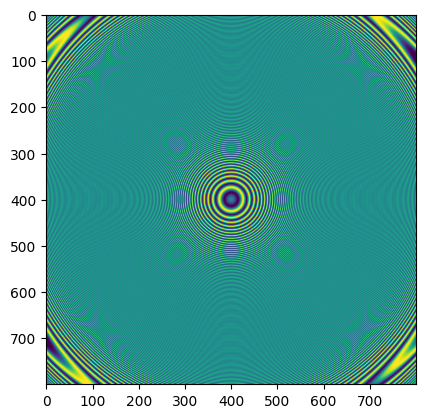

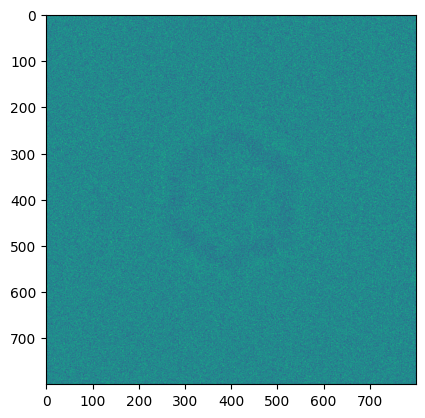

In [5]:
# output_folder = f"/home/wonjaec/mytigress/spike{grid_size}_ewald/"
# output_folder ='/home/mg6942/mytigress/spike256/../'
# volume_folder_input =  f"/home/wonjaec/mytigress/spike{grid_size}/"
dataset_dict = dataset.get_default_dataset_option()

# Fill these options with the path to preprocessed files
experiment_directory = output_folder
dataset_dict['ctf_file'] = output_folder + "ctf.pkl"
dataset_dict['poses_file'] = output_folder + "poses.pkl"
dataset_dict['particles_file'] = f"{output_folder}particles.{grid_size}.mrcs"


# Returns an object that knows everything about the dataset.
cryo = dataset.load_dataset_from_dict(dataset_dict, lazy = False)
print("n images", cryo.n_images)
del dataset_dict['ind']

plt.imshow(cryo.get_CTF_image(0))
plt.figure()
plt.imshow(cryo.get_image_real(0))

In [6]:
# cryo = dataset.load_cryodrgn_dataset( f"{output_folder}particles.{grid_size}.mrcs", output_folder + "poses.pkl", output_folder + "ctf.pkl", lazy = False)
from recovar import regularization, synthetic_dataset, noise, homogeneous, utils
sim_info = recovar.utils.pickle_load(output_folder + '/simulation_info.pkl')
noise_variance = sim_info['noise_variance']

gt_recon = synthetic_dataset.load_heterogeneous_reconstruction(sim_info, volumes_path_root = None)
gt_vol =gt_recon.get_mean()
noise_variance = sim_info['noise_variance']
signal_variance = utils.make_radial_image(regularization.average_over_shells(np.abs(gt_vol)**2, cryo.volume_shape), cryo.volume_shape)


(INFO) (simulator.py) (23-Aug-24 11:23:29) Loading volume 0


In [ ]:
# from recovar import core, utils, fourier_transform_utils
# ftu = fourier_transform_utils.fourier_transform_utils(jax.numpy)

# vol = gt_vol.reshape(cryo.volume_shape)
# vol_1 = ftu.get_idft3(vol)
# plt.imshow(np.sum(vol_1, axis=2).real)


In [9]:
pdb

Automatic pdb calling has been turned ON


In [10]:
utils.report_memory_device()

GPU mem in use:2; peak:24; total available:76, process mem in use:40


In [ ]:
from recovar import homogeneous
batch_size = 40
reload(homogeneous)
means, mean_prior, _, _  = homogeneous.get_mean_conformation_relion([cryo,cryo], 2*batch_size, noise_variance = noise_variance[0],  use_regularization = False, upsampling_factor =1)

plot_utils.plot_fsc(cryo, gt_vol,means['combined'])

keys = list((means.keys()))
for key in keys:
    if key != 'combined':
        del means[key]
del _, mean_prior
means['combined'] = np.array(means['combined'] )

In [12]:
utils.report_memory_device()

GPU mem in use:2; peak:24; total available:76, process mem in use:40


GPU mem in use:4; peak:24; total available:76, process mem in use:40
None
(INFO) (ewald.py) (13-Aug-24 19:29:00) batch size in Ewald LHS: 500
(WARNING) (ewald.py) (13-Aug-24 19:29:24) IS THIS RIGHT?!
(INFO) (ewald.py) (13-Aug-24 19:29:32) LHS done.
(WARNING) (ewald.py) (13-Aug-24 19:29:41) IS THIS RIGHT?!
GPU mem in use:4; peak:60; total available:76, process mem in use:53
None
(INFO) (ewald.py) (13-Aug-24 19:30:15) CG iter 1, residual: 0.009775920927019819
(INFO) (ewald.py) (13-Aug-24 19:30:26) CG iter 2, residual: 0.0003236395334492835
(INFO) (ewald.py) (13-Aug-24 19:30:38) CG iter 3, residual: 1.2067121949120764e-05
(INFO) (ewald.py) (13-Aug-24 19:30:49) CG iter 4, residual: 6.172134819911398e-07
(INFO) (ewald.py) (13-Aug-24 19:31:01) CG iter 5, residual: 1.0391734327975077e-07
(INFO) (ewald.py) (13-Aug-24 19:31:12) CG iter 6, residual: 9.888200478226838e-08
(INFO) (ewald.py) (13-Aug-24 19:31:24) CG iter 7, residual: 1.404575722363813e-07
(INFO) (ewald.py) (13-Aug-24 19:31:35) CG it

/tmp/ipykernel_784463/764882878.py:9: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



<Axes: >

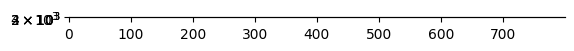

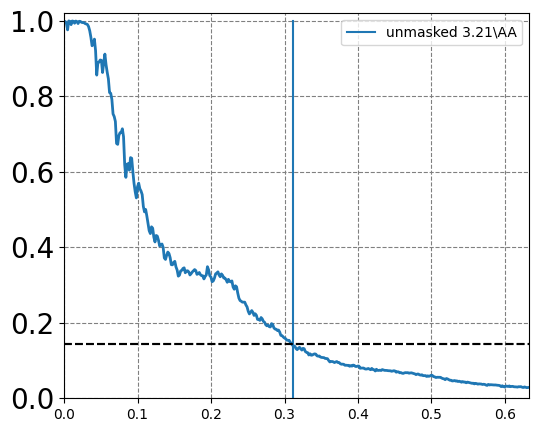

In [13]:
from recovar import ewald
reload(ewald)

batch_size = 500
x1, residuals = ewald.solve_ewald_least_squares(cryo, batch_size, "nearest", signal_variance*1, noise_variance.astype(np.float32), x0 = None, max_iter = 100)#means['combined'])
plt.semilogy(residuals)

from recovar import plot_utils
plt.imshow(x1.sum(axis=0).real)
plot_utils.plot_fsc(cryo, gt_vol, ftu.get_dft3(x1), threshold = 0.5)

In [14]:
x1 = np.array(x1).real

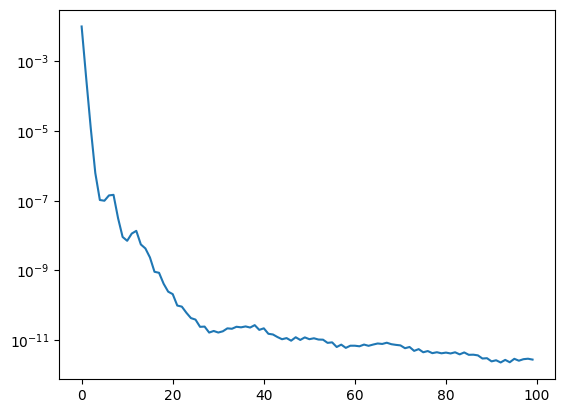

In [15]:

plt.semilogy(residuals)


In [16]:
# x1

In [17]:
utils.write_mrc(output_folder + 'recon_from_0.mrc', x1, voxel_size = cryo.voxel_size)


In [18]:
utils.write_mrc(output_folder + 'recon_from_0.mrc', x1, voxel_size = cryo.voxel_size)


In [ ]:
from recovar import homogeneous
batch_size = 40
reload(homogeneous)
means, mean_prior, _, _  = homogeneous.get_mean_conformation_relion([cryo,cryo], 2*batch_size, noise_variance = noise_variance[0],  use_regularization = False, upsampling_factor =1)

# get_mean_conformation(cryos, batch_size, noise_variance = None, 
plot_utils.plot_fsc(cryo, gt_vol,means['combined'])#, mask = csparc_mask)

In [ ]:
plot_utils.plot_fsc(cryo, gt_vol,means['combined'])#, mask = csparc_mask)

plane_csparc FSC score: 0.4574856021062623
plane_recovar FSC score: 0.4617069811822221
ewald_csparc FSC score: 1.2674493789672852
ewald_recovar FSC score: 1.2674493789672852


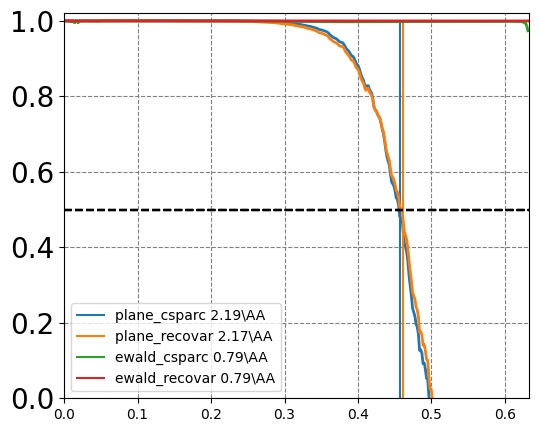

In [20]:
reload(plot_utils)
vol_dir = '/home/mg6942/mytigress/CS-ewald/'
J = '55'
csparc_mask = utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_mask_fsc.mrc")

recovar_dir = '/home/mg6942/mytigress/capsoid_800_ewald_noise_1e-6/'
J = '110'
# csparc_vol = utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_map.mrc")
csparc_vol = 0.5 * (utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_map_half_A.mrc") + utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_map_half_B.mrc") )
ax = plot_utils.plot_fsc(cryo, gt_vol,ftu.get_dft3(csparc_vol), name = 'plane_csparc', threshold = 1/2, mask = csparc_mask)


vol_dir = recovar_dir
# J = '55'
# ax = None
x1 = utils.load_mrc(f"{vol_dir}/recon_plane.mrc")
ax = plot_utils.plot_fsc(cryo, gt_vol,ftu.get_dft3(x1), name = 'plane_recovar', ax = ax, mask = csparc_mask, threshold = 1/2)

vol_dir = '/home/mg6942/mytigress/CS-ewald/'

J = '109'
# csparc_vol = utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_map.mrc")
csparc_vol = 0.5 * (utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_map_half_A.mrc") + utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_map_half_B.mrc") )
ax = plot_utils.plot_fsc(cryo, gt_vol,ftu.get_dft3(csparc_vol), name =  'ewald_csparc', ax = ax, threshold = 1/2, mask = csparc_mask)


# J = '57'
vol_dir = recovar_dir

x1 = utils.load_mrc(f"{vol_dir}/recon_1.mrc")

ax = plot_utils.plot_fsc(cryo, gt_vol,ftu.get_dft3(x1), name =  'ewald_recovar', ax = ax, mask = csparc_mask, threshold = 1/2)


# # J = '55'
# # csparc_vol = utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_map.mrc")
# ax = plot_utils.plot_fsc(cryo, gt_vol,means['combined'], name = 'plane_recovar', ax = ax)#, mask = csparc_mask)

# # J = '57'
# # csparc_vol = utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_map.mrc")
# ax = plot_utils.plot_fsc(cryo, gt_vol,ftu.get_dft3(x1), name =  'ewald_recovar', ax = ax)#, mask = csparc_mask)


plane_recovar FSC score: 0.43274900753883916
ewald_recovar FSC score: 0.3497792465301779


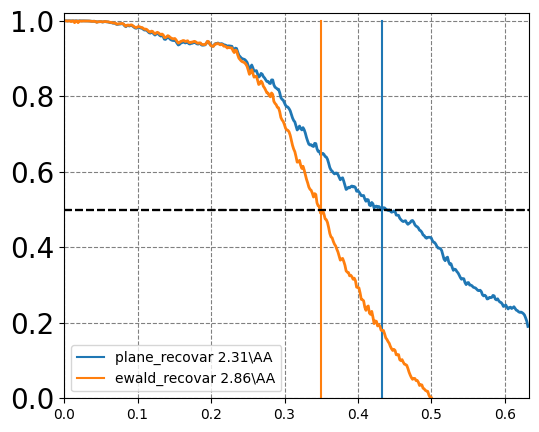

In [18]:
vol_dir = '/home/mg6942/mytigress/capsoid_800_ewald_noise_1e-1/'
# J = '55'
ax = None
x1 = utils.load_mrc(f"{vol_dir}/recon_1.mrc")
ax = plot_utils.plot_fsc(cryo, gt_vol,ftu.get_dft3(x1), name = 'plane_recovar', ax = ax, mask = csparc_mask, threshold = 1/2)

# J = '57'
x1 = utils.load_mrc(f"{vol_dir}/recon_plane.mrc")
ax = plot_utils.plot_fsc(cryo, gt_vol,ftu.get_dft3(x1), name =  'ewald_recovar', ax = ax, mask = csparc_mask, threshold = 1/2)


In [ ]:
reload(plot_utils)
# J = '55'
# csparc_vol = utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_map.mrc")
ax = plot_utils.plot_fsc(cryo, gt_vol,means['combined'], name = 'plane_recovar', ax = None)#, mask = csparc_mask)



In [ ]:
from recovar import utils, plot_utils
vol_dir = '/home/mg6942/mytigress/CS-ewald/'
Js = [ '55', '57', '58']
J = Js[0]
csparc_mask = utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_mask_fsc.mrc")
names = [ 'plane_csparc', 'ewald_cspard' ]
idx = 0 
for J in Js:
    csparc_vol = utils.load_mrc(f"{vol_dir}J{J}/J{J}_volume_map.mrc")
    plot_utils.plot_fsc(cryo, gt_vol,ftu.get_dft3(csparc_vol))#, mask = csparc_mask)
    idx+=1

In [ ]:
utils.report_memory_device()

In [ ]:
gt_vol.size**(1/3)

In [ ]:
plt.imshow(x1.sum(axis=0).real)
plt.figure()
plt.imshow(cryo.get_proj(means['combined'], axis=0))


In [ ]:
noise_image_variance = noise.make_radial_noise(noise_variance, cryo.image_shape)
diag_mean, _ = homogeneous.solve_least_squares_mean_iteration(cryo , None, noise_image_variance,  batch_size, None, disc_type = "nearest", return_lhs_rhs = True )
diag_mean = diag_mean.reshape(-1)
print(diag_mean.shape)
print(gt_vol.shape)

# plt.imshow(np.abs(np.diag(diag_mean)) > 0)

gt_vol


In [ ]:
plt.imshow(x1.sum(axis=0).real)


In [ ]:
(np.random.randn(*gt_vol.shape)).shape

In [ ]:
from recovar import mask
import jax.numpy as jnp
import scipy.sparse
import inspect
reload(ewald)
volume_shape = tuple(3*[grid_size])
mask_real = mask.get_radial_mask(cryo.volume_shape).reshape(-1)
mask_size = int(jnp.sum(mask_real))
# gt_vol = ftu.get_dft3(np.random.randn(*volume_shape)).reshape(-1) * cryo.get_valid_frequency_indices()# + 1j * np.random.randn(*gt_vol.shape) 

gt_vol = ftu.get_dft3(np.random.randn(*experiment_dataset.volume_shape)).reshape(-1) * experiment_dataset.get_valid_frequency_indices(29) # + 1j * np.random.randn(experiment_dataset.volume_size)


In [ ]:
masked_vol = ewald.vec_masked(gt_vol.real, gt_vol.imag, cryo.volume_shape)

y_ewald_temp = ewald.matvec_experiments(masked_vol, cryo, batch_size, "nearest", signal_variance, noise_variance)
y_ewald_r, y_ewald_i = ewald.unvec_masked(y_ewald_temp, cryo.volume_shape, mask_size)
y_ewald = y_ewald_r + y_ewald_i * 1j

diag_mean_masked = ewald.vec_masked(diag_mean.real, diag_mean.real, cryo.volume_shape)

y_planar_temp = diag_mean_masked * masked_vol
y_planar_r, y_planar_i = ewald.unvec_masked(y_planar_temp, cryo.volume_shape, mask_size)
y_planar = y_planar_r + y_planar_i * 1j

In [ ]:
print(y_ewald.shape)
print(y_planar.shape)
print(np.linalg.norm(y_ewald - y_planar) / np.linalg.norm(y_planar))

plt.imshow(np.sum(y_ewald.reshape(cryo.volume_shape), axis=2).real)
plt.figure()
plt.imshow(np.sum(y_planar.reshape(cryo.volume_shape), axis=2).real)

In [ ]:
reload(ewald)
n_images = 1

ctf_params, rotation_matrices, translations = simulator.random_sampling_scheme(n_images, grid_size, seed =0 )
image_shape = (grid_size, grid_size)
volume_shape = (grid_size, grid_size, grid_size)
CTF_fun = cryo.CTF_fun
# lam = ewald.volt_to_wavelength(300)

phase_shift = np.arcsin(ctf_params[:,5]) / np.pi * 180
ctf_params[:,5] = 0
ctf_params[:,6] = phase_shift
# ctf_params[:,:2] = 0 
# ctf_params[:,4] = 0 

# rotation_matrices[0] = np.eye(3)
gt_vol =gt_recon.volumes[0].copy() * cryo.get_valid_frequency_indices(29)

# gt_vol.real=0
# y_inp = np.concatenate([gt_, volume_imag], axis=-1)
A_y_inp = ewald.ewald_sphere_forward_model(gt_vol.real, gt_vol.imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size,'nearest' )
A_y_inp = A_y_inp[0] + A_y_inp[1] * 1j
A_y_planar = core.forward_model_from_map(gt_vol, ctf_params, rotation_matrices, image_shape, volume_shape, voxel_size, CTF_fun,'nearest')

In [ ]:
reload(ewald)
vv = ewald.adjoint_ewald_sphere_forward_model(A_y_inp[0], A_y_inp[1], rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, 'nearest' )
vv2 = vv[0] + vv[1]*1j


In [ ]:
plt.figure()
plt.imshow(vv2.reshape(volume_shape)[32].real)
plt.colorbar()

plt.figure()
plt.imshow(vv2.reshape(volume_shape).sum(axis=0).real)
plt.colorbar()

In [ ]:
np.dot(np.conj(gt_vol), vv2).real + np.dot(np.conj(gt_vol), vv2).imag

In [ ]:
np.dot(np.conj(A_y_inp.reshape(-1)), A_y_inp.reshape(-1))

In [ ]:
# np.linalg.norm(A_y_planar - A_y_inp) / np.linalg.norm(A_y_planar)

In [ ]:
gt_vol2 = gt_vol# ftu.get_dft3(np.random.randn(*volume_shape)).reshape(-1) * cryo.get_valid_frequency_indices()

In [ ]:
plt.imshow((A_y_inp.reshape(image_shape) - A_y_planar.real.reshape(image_shape)).real)
plt.colorbar()
plt.figure()
print(np.linalg.norm(A_y_planar - A_y_inp) / np.linalg.norm(A_y_planar))

plt.imshow((A_y_inp.reshape(image_shape).real ))#[32])
plt.colorbar()
plt.figure()

plt.imshow((A_y_planar.real.reshape(image_shape).real))#[32])
plt.colorbar()
plt.figure()

# plt.imshow(V1_real.real.reshape(image_shape))
# plt.colorbar()

In [ ]:
disc_type ='nearest'
reload(ewald)
V1_real, V1_imag = ewald.compute_A_t_Av_ewald_sphere_forward_model(gt_vol.real, gt_vol.imag, rotation_matrices, ctf_params, 1, image_shape, volume_shape, voxel_size, disc_type)

In [ ]:
experiment_dataset = cryo
diag = core.compute_A_t_Av_forward_model_from_map(np.ones_like(gt_vol), ctf_params, rotation_matrices,
                                           experiment_dataset.image_shape, experiment_dataset.volume_shape, experiment_dataset.voxel_size,
                                           experiment_dataset.CTF_fun, disc_type)

# V2 = V2[0]

V2 = gt_vol * diag[0]



In [ ]:
A_y_planar2 = core.forward_model_from_map(gt_vol2, ctf_params, rotation_matrices, image_shape, volume_shape, voxel_size, CTF_fun,'nearest')

In [ ]:
A_y_planar = A_y_planar.reshape(-1)
A_y_planar2 = A_y_planar2.reshape(-1)

In [ ]:
# np.linalg.norm(A_y_planar)**2
np.dot(np.conj(A_y_planar2), A_y_planar)

In [ ]:
np.dot(np.conj(V2), (gt_vol2))

In [ ]:
np.dot(V1_real, gt_vol2.real) + np.dot(V1_imag, gt_vol2.imag)

In [ ]:
np.dot(np.conj(V1_real + 1j* V1_imag) , (gt_vol2))

In [ ]:
np.linalg.norm(X3.real - X4.real)  / np.linalg.norm(X3.real)

In [ ]:
np.linalg.norm(X3 - X4) / np.linalg.norm(X3)

In [ ]:
X3 = V1_real + 1j * V1_imag
X3 = ftu.get_idft3(X3.reshape(volume_shape))
plt.imshow(X3.sum(axis=1).real)


X4 = V2
X4 = ftu.get_idft3(X4.reshape(volume_shape))
plt.figure()
plt.imshow(X4.sum(axis=1).real)

In [ ]:
plt.imshow((V1_real.reshape(volume_shape) - V2.real.reshape(volume_shape))[32])
plt.colorbar()
plt.figure()

plt.imshow((V1_real.reshape(volume_shape) )[32])
plt.colorbar()
plt.figure()

plt.imshow((V2.real.real.reshape(volume_shape))[32])
plt.colorbar()
plt.figure()


plt.figure()
plt.imshow((V1_real.reshape(volume_shape) - V2.real.reshape(volume_shape)).sum(axis=0))
plt.colorbar()
plt.figure()

plt.imshow((V1_real.reshape(volume_shape) ).sum(axis=0))
plt.colorbar()
plt.figure()

plt.imshow((V2.real.real.reshape(volume_shape)).sum(axis=0))
plt.colorbar()
plt.figure()


# plt.imshow(V1_real.real.reshape(image_shape))
# plt.colorbar()

In [ ]:
print(np.linalg.norm (A_y_inp - A_y_planar) / np.linalg.norm (A_y_planar))

plt.imshow(A_y_inp.real.reshape(image_shape) - A_y_planar.real.reshape(image_shape))
plt.colorbar()
plt.figure()
plt.imshow(A_y_planar.real.reshape(image_shape))
plt.colorbar()

In [ ]:
from recovar import mask
import jax.numpy as jnp
import scipy.sparse
import inspect
reload(ewald)
mask_real = mask.get_radial_mask(cryo.volume_shape).reshape(-1)
mask_size = int(jnp.sum(mask_real))

x1_unvec = ewald.unvec_masked(x1, cryo.volume_shape, mask_size)

In [ ]:
x1_unvec = x1_unvec[0] + x1_unvec[1] * 1j
print(x1_unvec.shape)
# x1_unvec = x1_unvec.reshape((cryo.volume_shape))
# final_x1 = ftu.get_idft3(x1_unvec)
# print(final_x1.shape)


In [ ]:
x1_f = x1_unvec.reshape(cryo.volume_shape)

In [ ]:
from recovar import core, utils, fourier_transform_utils
ftu = fourier_transform_utils.fourier_transform_utils(jax.numpy)

x1_final = ftu.get_idft3(x1_f)
plt.imshow(np.sum(x1_final, axis=0).real.T)
plt.figure()

true_vol = gt_vol.reshape(cryo.volume_shape)
true_true_vol = ftu.get_idft3(true_vol)
plt.imshow(np.sum(true_true_vol, axis=0).real.T)

print(np.linalg.norm(x1_final - true_true_vol)/np.linalg.norm(x1_final))

In [ ]:
def planar_model(dataset):
    noise_variance_image = noise.make_radial_noise(noise_variance, cryo.image_shape)
    diag_mean, _ = homogeneous.solve_least_squares_mean_iteration(dataset , None, noise_variance_image,  batch_size, gt_vol, disc_type = "nearest", return_lhs_rhs = True )
    return diag_mean

noise_variance.shape
dm = planar_model(cryo).reshape(-1)
print(dm.shape)

In [ ]:
plt.imshow(dm_diag.real)

In [ ]:
residuals[-1]

In [ ]:
batch_size = 100
disc_type = "nearest"

In [ ]:
from recovar import mask
import jax.numpy as jnp
import scipy.sparse
import inspect
reload(ewald)

In [ ]:
# Linearity Tests

reload(ewald)
mask_real = mask.get_radial_mask(cryo.volume_shape).reshape(-1)
mask_size = int(jnp.sum(mask_real))

x_1 = np.random.rand(mask_size * 2 - 1)
x_2 = np.random.rand(mask_size * 2 - 1)

result1 = ewald.matvec_experiments(x_1, cryo, batch_size, "nearest", signal_variance, noise_variance)
result2 = ewald.matvec_experiments(x_2, cryo, batch_size, "nearest", signal_variance, noise_variance)
result3 = ewald.matvec_experiments(x_1 + x_2, cryo, batch_size, "nearest", signal_variance, noise_variance)

print(np.linalg.norm(result1 + result2 - result3) / np.linalg.norm(result3))

In [ ]:
reload(ewald)
from recovar import core, utils, fourier_transform_utils
ftu = fourier_transform_utils.fourier_transform_utils(jax.numpy)
vol_spatial_mask = mask.get_radial_mask(tuple(3*[grid_size]))#, radius = grid_size-2)


vol = gt_vol.reshape((grid_size, grid_size, grid_size))
# vol = ftu.get_idft3(gt_vol.reshape((16, 16, 16)))
vol *= vol_spatial_mask 
volume_real = vol.real.reshape(-1)
volume_imag = vol.imag.reshape(-1)

n_images = 1

ctf_params, rotation_matrices, translations = simulator.random_sampling_scheme(n_images, grid_size, seed =0 )
image_shape = (grid_size, grid_size)
volume_shape = (grid_size, grid_size, grid_size)
# lam = ewald.volt_to_wavelength(300)

y_inp = np.concatenate([volume_real, volume_imag], axis=-1)
A_y_inp = ewald.ewald_sphere_forward_model(volume_real, volume_imag, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size,'nearest_neighbor' )
A_y_inp_vec = np.concatenate(A_y_inp, axis=-1).reshape(-1)

x = A_y_inp
im_mask = mask.get_radial_mask(tuple(2*[grid_size])).reshape(-1)
test_x = [ np.random.randn(*x[0].shape) * im_mask, np.random.randn(*x[1].shape)* im_mask]
test_x_vec = np.concatenate(test_x, axis=-1).reshape(-1)

At_test_x = ewald.adjoint_ewald_sphere_forward_model(test_x[0], test_x[1], rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size, 'nearest_neighbor' )
At_test_x_vec = np.concatenate(At_test_x, axis=-1)

print(np.dot(test_x_vec, A_y_inp_vec))
print(np.dot(At_test_x_vec, y_inp))

# If adjoint is correct, then < x , Ay > === < A^T x, y >
print('rel error: ', np.abs(np.dot(test_x_vec, A_y_inp_vec) - np.dot(At_test_x_vec, y_inp)) / np.abs(np.dot(At_test_x_vec, y_inp)))


In [ ]:
reload(ewald)
m = mask_size * 2 - 1
print(m)
I_m = np.eye(m)
ATA_matrix = np.zeros((m, m))
for i in range(m):
#     if (i + 1) % 500 == 0:
#         print('This iteration:', i + 1)
    x = np.array(I_m[:,i])
    ATA_matrix[:,i] = ewald.matvec_experiments(x, cryo, batch_size, "nearest", signal_variance, noise_variance)


In [ ]:
ATA_yes = np.abs(ATA_matrix)>1

plt.imshow(np.abs(ATA_yes))

np.diag(np.where(np.diag(ATA_matrix)<0))

In [ ]:
row = ATA_matrix[0, :]
idxs = np.where(np.abs(row) > 0)
row[idxs]

In [ ]:
reload(ewald)

n_images = 1

ctf_params, rotation_matrices, translations = simulator.random_sampling_scheme(n_images, grid_size, seed =0 )


k = volume_real.size
l = int(grid_size ** 2)
identity = np.eye(k)
A_r = np.zeros((l, k))
A_i = np.zeros((l, k))


In [ ]:
reload(ewald)

lam = ewald.volt_to_wavelength(300)

coords = ewald.batch_get_nearest_gridpoint_indices_ewald_sphere(rotation_matrices, image_shape, volume_shape, grid_size, voxel_size, lam)

slices = ewald.map_coordinates_on_ewald_sphere(vol, rotation_matrices, image_shape, volume_shape, grid_size, voxel_size, lam,  0)


In [ ]:
print(slices.reshape(-1).shape)
print(vol.reshape(-1).shape)

In [ ]:
print(coords)

In [ ]:
S = np.zeros((l, k))
coords = coords.reshape(-1)
S[np.arange(l), coords] = 1

In [ ]:
def apply_A_r_sin(y, chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n):
    z = 0.5 * (np.sin(chi) * (y[idxs]))
    zf = 0.5 * (np.sin(chi) * (y[flipped_idxs] * kept_flipped_idxs))
    return z, zf

def apply_A_r_cos(y, chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n):
    z = 0.5 * (np.cos(chi) * (y[idxs + n]))
    zf = 0.5 * (np.cos(chi) * (y[n + flipped_idxs] * kept_flipped_idxs))
    return z, zf

def apply_A_i_sin(y, chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n):
    z = 0.5 * np.sin(chi) * y[idxs + n]
    zf = 0.5 * np.sin(chi) * (-y[n + flipped_idxs] * kept_flipped_idxs)
    z[zero_idx], zf[zero_idx] = y[zero_idx + n], y[zero_idx + n]
    return z, zf

def apply_A_i_cos(y, chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n):
    z = -0.5 * np.cos(chi) * (y[idxs])
    zf = 0.5 * np.cos(chi) * (y[flipped_idxs] * kept_flipped_idxs)
    z[zero_idx], zf[zero_idx] = y[zero_idx + n], y[zero_idx + n]
    return z, zf

def apply_A_r(image_shape, y, chi):
    n = image_shape[0] ** 2
    m = 2*n
    y = y.reshape(m,)
    idxs = np.arange(n)
    flipped_idxs = ewald.get_flipped_indices(image_shape)
    kept_flipped_idxs = (np.not_equal(flipped_idxs, -np.ones(n)))
    zero_idx = int(n/2 + (n**0.5)/2)
    C_1, C_1f = apply_A_r_sin(y, chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n)
    C_2, C_2f = apply_A_r_cos(y, chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n)
    return C_1 + C_1f + C_2 + C_2f

def apply_A_i(image_shape, y, chi):
    n = image_shape[0] ** 2
    m = 2*n
    y = y.reshape(m,)
    idxs = np.arange(n)
    flipped_idxs = ewald.get_flipped_indices(image_shape)
    kept_flipped_idxs = (np.not_equal(flipped_idxs, -np.ones(n)))
    zero_idx = int(n/2 + (n**0.5)/2)
    C_1, C_1f = apply_A_i_sin(y, chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n)
    C_2, C_2f = apply_A_i_cos(y, chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n)
    return C_1 + C_1f + C_2 + C_2f

In [ ]:
def apply_A(image_shape, y, chi):
    n = image_shape[0] ** 2
    m = 2*n
    y = y.reshape(m,)
    idxs = np.arange(n)
    image_count = 1 
    z = np.zeros(m * image_count)
    for i in range(image_count):
        z_position_r = i * n
        z_position_i = z_position_r + int(z.size/2)
        z[z_position_r + idxs] = apply_A_r(image_shape, y, chi)
        z[z_position_i + idxs] = apply_A_i(image_shape, y, chi)
    return z


In [ ]:
ATA = apply_A(image_shape, np.random.rand(l * 2), np.random.rand(l))

In [ ]:
def apply_A_r(y, chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n):
    z = np.zeros(n)
    z[idxs] = np.sin(chi) * (y[idxs] + y[flipped_idxs] * kept_flipped_idxs)
    z[idxs] += np.cos(chi) * (y[idxs + n] + y[n + flipped_idxs] * kept_flipped_idxs)
    return 0.5 * z

def apply_A_i(y, chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n):
    z = np.zeros(n)
    z[idxs] = -np.cos(chi) * (y[idxs] - y[flipped_idxs] * kept_flipped_idxs) 
    z[idxs] += np.sin(chi) * (y[idxs + n] - y[n + flipped_idxs] * kept_flipped_idxs)
    z[zero_idx] = y[zero_idx + n]
    return 0.5 * z

def apply_A(image_shape, y, chi):
    n = image_shape[0] ** 2
    m = 2*n
    y = y.reshape(m,)
    idxs = np.arange(n)
    image_count = 1
    z = np.zeros(m * image_count)
    flipped_idxs = ewald.get_flipped_indices(image_shape)
    kept_flipped_idxs = (np.not_equal(flipped_idxs, -np.ones(n)))
    zero_idx = int(n/2 + (n**0.5)/2)
    for i in range(image_count):
        z_position_r = i * n
        z_position_i = z_position_r + int(z.size/2)
        current_chi = chi
        z[z_position_r + idxs] = apply_A_r(y, current_chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n)
        z[z_position_i + idxs] = apply_A_i(y, current_chi, flipped_idxs, kept_flipped_idxs, idxs, zero_idx, n)
    return z

In [ ]:
image = S @ vol
image = np.concatenate((image.real, image.imag))
freqs = ftu.get_k_coordinate_of_each_pixel(image_shape, voxel_size=voxel_size, scaled=True)
chi = ewald.get_chi(freqs, ctf_params[0, 0], ctf_params[0, 1], ctf_params[0, 2], ctf_params[0, 3],ctf_params[0, 4],ctf_params[0, 5],ctf_params[0, 6],ctf_params[0, 7])

In [ ]:
p = image.size 
I_p = np.eye(p)
A = np.zeros((p, p))

for i in range(p):
    A[:,i] = apply_A(image_shape, I_p[:, i], chi)


In [ ]:
d = np.diag(ATA_matrix)
d


In [ ]:
for i in range(k):
    if (i + 1) % 500 == 0:
        print('This iteration:', i + 1)
    x = identity[:, i]
    A_r[:, i], A_i[:, i] = ewald.ewald_sphere_forward_model(x, x, rotation_matrices, ctf_params, image_shape, volume_shape, voxel_size,'nearest_neighbor' )

In [ ]:
plt.imshow(np.abs(A_i[:, :])>0)
plt.figure()
plt.imshow(np.abs(A_i[:, :1000])>0)
plt.figure()
plt.imshow(np.abs(A_i[:, 1000:2000])>0)
plt.figure()
plt.imshow(np.abs(A_i[:, 2000:3000])>0)
plt.figure()
plt.imshow(np.abs(A_i[:, 3000:])>0)
plt.figure()


# plt.imshow(np.abs(A_i[:, :])>0)
# plt.figure()
# plt.imshow(np.abs(A_r.T @ A_r) > 0 )
# plt.figure()
# plt.imshow(np.abs(A_i.T @ A_i) > 0 )
# plt.figure()


In [ ]:
A = np.concatenate((A_r, A_i))
AT = A.T
ATA = AT @ A

idxs = np.where(np.abs(ATA) > 0)


plt.imshow(np.abs(ATA)>0)

In [ ]:
reload(ewald)
ATA_diagonal = np.zeros((m, m))

for i in range(m):
#     if (i + 1) % 500 == 0:
#         print('This iteration:', i + 1)
    x = np.array(I_m[:,i])
    ATA_diagonal[:,i] = ewald.diagonal_matvec_experiments(x, cryo, batch_size, "nearest", signal_variance, noise_variance)


In [ ]:
plt.imshow(np.abs(ATA_diagonal)>0)
plt.figure()
plt.imshow(np.abs(np.diag(np.diag(ATA_matrix)))>0)
np.linalg.norm(ATA_diagonal - np.diag(np.diag(ATA_matrix))) / np.linalg.norm(np.diag(np.diag(ATA_matrix)))
print(np.diag(np.diag(ATA_matrix)))
print(ATA_diagonal)

In [ ]:
reload(ewald)
x2, _ = ewald.solve_ewald_least_squares_2(cryo, batch_size, "nearest", signal_variance, noise_variance, ATA_matrix)

In [ ]:
vol1_r, vol1_i = ewald.unvec_masked(x1, cryo.volume_shape, mask_size)
vol2_r, vol2_i = ewald.unvec_masked(x2, cryo.volume_shape, mask_size)

vol1 = (vol1_r + vol1_i * 1j).reshape(cryo.volume_shape)
vol2 = (vol2_r + vol2_i * 1j).reshape(cryo.volume_shape)

plt.imshow((np.sum(vol1,axis=0)).real)
plt.figure()
plt.imshow((np.sum(vol2,axis=0)).real)

In [ ]:
np.linalg.norm(x1 - x2) / np.linalg.norm(x1)

In [ ]:
plt.imshow(np.abs(ATA_matrix)>0)

row = ATA_matrix[:, 0]
idxs1 = np.where(np.abs(row) > 0)
row[idxs1]

In [ ]:
def diag(x):
    return np.diag(x)
d = np.linalg.inv(diag(diag(ATA_matrix)))

In [ ]:
np.linalg.cond(d @ ATA_matrix)

In [ ]:
d2 = ATA_matrix @ np.linalg.inv(diag(np.ones_like(ATA_matrix[0])))


In [ ]:
np.linalg.cond(d2)

In [ ]:
np.linalg.inv(ATA_matrix)

In [ ]:
eigs, eigenvecs = np.linalg.eig(ATA_matrix)

In [ ]:
np.where(eigs < 0)

In [ ]:
x_experiment_real, x_experiment_imag = ewald.unvec_masked(x1, cryo.volume_shape, mask_size)

x_experiment = x_experiment_real + x_experiment_imag * 1j

In [ ]:
np.linalg.norm(x_experiment - gt_vol) / np.linalg.norm(gt_vol)

In [ ]:
from recovar import core, utils, fourier_transform_utils
ftu = fourier_transform_utils.fourier_transform_utils(jax.numpy)


In [ ]:
vol1 = ftu.get_idft3(gt_vol.reshape(volume_shape))

In [ ]:
vol2 = ftu.get_idft3(x_experiment.reshape(volume_shape))

In [ ]:
plt.imshow(np.sum(vol1.real, axis=0))
plt.figure()
plt.imshow(np.sum(vol2.real, axis=0))
